In [1]:
import os

import keras
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mplimg

import PIL
from PIL import Image

import sklearn
#from sklearn.

Using TensorFlow backend.


In [2]:
datapath = 'data/image/art/dataset_updated/training_set/iconography'
image_names = [_ for _ in os.listdir(datapath) if '.j' in _ or '.p' in _]

In [4]:
def getImagePath(x):
    return os.path.join(datapath, image_names[x])

<class 'PIL.JpegImagePlugin.JpegImageFile'>


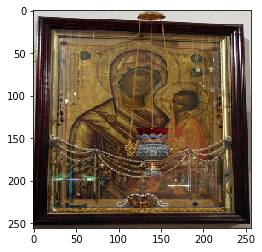

In [86]:
testimg = Image.open(getImagePath(12))
print(type(testimg))
testimg = testimg.resize((256, 256))
plt.imshow(testimg)

In [12]:
#RAM destroyer 5000
size = 256
images = []
for i in range(len(image_names)):
    _image = Image.open(getImagePath(i))
    _image = _image.resize((size, size))
    _image = _image.convert('RGB')
    images += [_image]

/home/mkeays/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6029312 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/mkeays/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1311848 bytes but only got 785. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/home/mkeays/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 8. 
  warnings.warn(str(msg))


In [13]:
imageData = np.array([np.array(list(images[_].getdata())).reshape(size, size, -1) for _ in range(len(images))])
#imageData = np.array([(np.array(list(images[_].convert('RGB').getdata())) if (np.array(list(images[_].convert('RGB').getdata())).shape[-1] is 3) else np.delete(np.array(list(images[_].convert('RGB').getdata())), -1, axis = 1)).reshape(size, size, -1) for _ in range(len(images))])

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Reshape, Flatten
from keras.layers import pooling, Conv2DTranspose, Conv2D, BatchNormalization
from keras.activations import relu, selu, sigmoid, tanh, linear, softmax
from keras.optimizers import Adam, SGD

In [15]:
#Generate a sequence of words by outputting a flat binary map, in the shape of a record of xb
def createGenerator():
    gen = Sequential()
    gen.add(Dense(48, input_shape = (8,), activation = 'relu'))
    gen.add(Dense(256, activation = 'relu'))
    gen.add(Dense(1024, activation = 'relu'))
    gen.add(Reshape((32,32, 1)))
    gen.add(Conv2DTranspose(3, (3, 3), #output_shape=(None, 3, 64, 64),
            strides=(2, 2),
            padding='same',
            input_shape=(1, 32, 32),
            activation = 'sigmoid'))
    gen.add(Conv2DTranspose(3, (3, 3), #output_shape=(None, 3, 128, 128),
            strides=(2,2),
            padding='same',
            activation = 'sigmoid'))
    gen.add(Conv2DTranspose(3, (3, 3), #output_shape=(None, 3, 256, 256),
            strides=(2,2),
            padding='same',
            activation = 'relu'))
    gen.add(BatchNormalization())
    return gen

def compileGAN(g, d):
    g.add(d)
    initial_learningrate = 0.01
    _sgd = SGD(lr = initial_learningrate)
    g.compile(loss = "mse", optimizer = _sgd, metrics=["accuracy"])

In [18]:
def generatorBatch(g, x):
    gen_inp = np.abs(np.random.standard_normal((x, 8)))
    gen_batch = g.predict(gen_inp)#.reshape(batchsize, n, -1)
    return gen_batch
#testbatch = generatorBatch(g, imageData.shape[0])

In [29]:
def genDesTrainingInp(real, batch):
    des_X = np.array([real, batch.astype('int64')]).reshape(-1, size, size, 3)
    des_Y = np.array([1]*real.shape[0] + [-1]*batch.shape[0])
    return des_X, des_Y

def fullBatch(x):
    full_X = np.abs(np.random.standard_normal((x, 8)))
    full_Y = np.array([1]*x) #[[0, 1]] was not working???
    return full_X, full_Y

In [440]:
g = createGenerator()
pred = g.predict(np.array([[1,1,1,1,1,1,1,1]]))

In [27]:
def displayGeneration(x):
    outimg = [tuple(int(256 * __) for __ in _) for _ in x[:,:].reshape(-1, 3)]
    outimgtest = Image.Image.copy(images[0])
    outimgtest.putdata(data=outimg)
    return outimgtest

In [316]:
d = createDescriminator()
d.predict([pred])

array([[-0.03903431]], dtype=float32)

In [20]:
def createDescriminator():
    des = Sequential()
    des.add(Conv2D(12, 3,
        padding='same',    
        input_shape=(256, 256, 3)))
    des.add(Conv2D(6, 3,
        padding='same'))
    des.add(Flatten())
    des.add(Dense(512, activation = 'relu'))
    des.add(Dense(128, activation = 'relu'))
    #des.add(Dense(2, activation = 'softmax'))
    des.add(Dense(1, activation = 'tanh'))
    return des
    
def compileDescriminator(d):
    initial_learningrate = 0.02
    _sgd = SGD(lr = initial_learningrate)
    d.compile(loss = "mse", optimizer = _sgd, metrics=["accuracy"])
    return d

In [31]:
full_history = []
big_epoch, m_epochs = 1, 1
print('hold on tight...')
g = createGenerator()
d = createDescriminator()

#print('Before:')
#print(decodeResult(g.predict([[[1,2,3,4,5,6,7,0]]]).reshape(10, -1)))

for i in range(big_epoch):
    print('================EPOCH #{}================'.format(i))
    batch = generatorBatch(g, 10)#(g, imageData.shape[0])
    tx, ty = genDesTrainingInp(imageData[:10], batch)#(imageData, batch)
    d = compileDescriminator(d)
    full_history += [d.fit(tx, ty, epochs=m_epochs, batch_size=76)]

    x, y = fullBatch(10)#(imageData.shape[0])
    g.add(keras.models.clone_model(d))
    initial_learningrate = 0.01
    _sgd = SGD(lr = initial_learningrate)
    g.compile(loss = "mse", optimizer = _sgd, metrics=["accuracy"])
    full_history += [g.fit(x, y, epochs=m_epochs, batch_size=128)]
    g.pop()
results = generatorBatch(g, 1)

#print('After:')
#print(decodeResult(g.predict([[[1,2,3,4,5,6,7,0]]]).reshape(10, -1)))

hold on tight...
================EPOCH #0================
Epoch 1/1
20/20 [==============================] - 951s 48s/step - loss: 1.9000 - acc: 0.1500
Epoch 1/1


ResourceExhaustedError: OOM when allocating tensor with shape[393216,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[Node: dense_16_1/kernel/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_16_1/kernel, dense_16_1/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'dense_16_1/kernel/Assign', defined at:
  File "/home/mkeays/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mkeays/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/mkeays/anaconda3/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/mkeays/anaconda3/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/mkeays/anaconda3/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-4ab3f320418e>", line 18, in <module>
    g.add(keras.models.clone_model(d))
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/models.py", line 249, in clone_model
    return _clone_sequential_model(model, input_tensors=input_tensors)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/models.py", line 203, in _clone_sequential_model
    return Sequential(layers=layers, name=model.name)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py", line 92, in __init__
    self.add(layer)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/engine/sequential.py", line 187, in add
    output_tensor = layer(self.outputs[0])
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 432, in __call__
    self.build(input_shapes[0])
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 872, in build
    constraint=self.kernel_constraint)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/engine/base_layer.py", line 252, in add_weight
    constraint=constraint)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 399, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 387, in _init_from_args
    validate_shape=validate_shape).op
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 283, in assign
    validate_shape=validate_shape)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 60, in assign
    use_locking=use_locking, name=name)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/mkeays/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[393216,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[Node: dense_16_1/kernel/Assign = Assign[T=DT_FLOAT, use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_16_1/kernel, dense_16_1/random_uniform)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [32]:
results = generatorBatch(g, 1)

FailedPreconditionError: Attempting to use uninitialized value dense_16_1/kernel
	 [[Node: dense_16_1/kernel/read = Identity[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_16_1/kernel)]]